# Tree-based methods
## Classification trees
- The` tree` library is used to construct classification and regression trees.
- We first use classification trees to analyze the `Carseats` data set.
- In these data, `Sales` is a continuous variable, and so we begin by recoding it as a binary variable.
- We use the` ifelse()` function to create a variable, called `High`, which takes on a value of Yes if the `Sales` variable exceeds 8, and takes on a value of No otherwise.

In [1]:
# Fitting Classification Trees
library(tree)
library(ISLR)
attach(Carseats)
High=ifelse(Sales<=8,"No","Yes")
Carseats=data.frame(Carseats,High)

- We now use the `tree()` function to fit a classification tree in order to predict `High` using all variables but `Sales`.
- The syntax of the `tree()` function is quite similar to that of the `lm()` function.

In [2]:
tree.carseats=tree(High~.-Sales,Carseats)

- The `summary()` function lists the variables that are used as internal nodes in the tree, the number of terminal nodes, and the (training) error rate.

In [3]:
summary(tree.carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

- We see that the training error rate is 9 %. 
- For classification trees, the deviance reported in the output of `summary()` is given by
$$-2\sum_{m}\sum_{k}n_{mk}\log \hat{p}_{mk}$$
where $n_{mk}$ is the number of observations in the m-th terminal node that belong to the k-th class. 
- A small deviance indicates a tree that provides a good fit to the (training) data. 
- The residual mean deviance reported is simply the deviance divided by n−|T0|, which in this case is 400−27 = 373.

- We use the `plot()` function to display the tree structure, 
- and the` text()` function to display the node labels. 
- The argument `pretty=0` instructs R to include the category names for any qualitative predictors, rather than simply displaying a letter for each category.

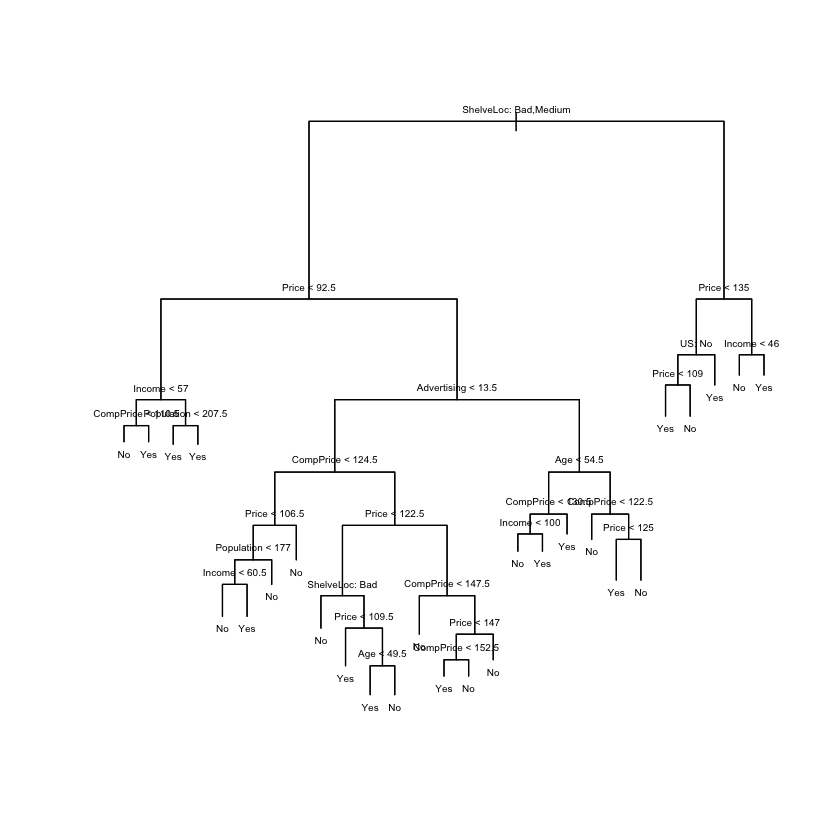

In [4]:
plot(tree.carseats)
text(tree.carseats,pretty=0,cex = 0.5)

- If we just type the name of the tree object, R prints output corresponding to each branch of the tree:
- the split criterion (e.g. Price<92.5)
- the number of observations in that branch
- the deviance
- the overall predictionfor the branch (Yes or No)
- and the fraction of observations in that branch that take on values of Yes and No. 
- Branches that lead to terminal nodes are indicated using asterisks (`*`).

In [5]:
tree.carseats

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 400 541.500 No ( 0.59000 0.41000 )  
    2) ShelveLoc: Bad,Medium 315 390.600 No ( 0.68889 0.31111 )  
      4) Price < 92.5 46  56.530 Yes ( 0.30435 0.69565 )  
        8) Income < 57 10  12.220 No ( 0.70000 0.30000 )  
         16) CompPrice < 110.5 5   0.000 No ( 1.00000 0.00000 ) *
         17) CompPrice > 110.5 5   6.730 Yes ( 0.40000 0.60000 ) *
        9) Income > 57 36  35.470 Yes ( 0.19444 0.80556 )  
         18) Population < 207.5 16  21.170 Yes ( 0.37500 0.62500 ) *
         19) Population > 207.5 20   7.941 Yes ( 0.05000 0.95000 ) *
      5) Price > 92.5 269 299.800 No ( 0.75465 0.24535 )  
       10) Advertising < 13.5 224 213.200 No ( 0.81696 0.18304 )  
         20) CompPrice < 124.5 96  44.890 No ( 0.93750 0.06250 )  
           40) Price < 106.5 38  33.150 No ( 0.84211 0.15789 )  
             80) Population < 177 12  16.300 No ( 0.58333 0.41667 )  
              160) Income < 60.5 6   0

- In order to properly evaluate the performance of a classification tree on these data, we must estimate the test error rather than simply computing the training error. 
- We split the observations into a training set and a test set, build the tree using the training set, and evaluate its performance on the test data. 

In [6]:
set.seed(2)
train=sample(1:nrow(Carseats), 200)
Carseats.test=Carseats[-train,]
High.test=High[-train]
tree.carseats=tree(High~.-Sales,Carseats,subset=train)

- The `predict() `function can be used for this purpose. 
- In the case of a classification tree, the argument `type="class"` instructs R to return the actual class prediction.
- This approach leads to correct predictions for around 71.5% of the locations in the test data set.

In [7]:
tree.pred=predict(tree.carseats,Carseats.test,type="class")
head(tree.pred)
table(tree.pred,High.test)
(86+57)/200

[1] Yes No  No  Yes No  No 
Levels: No Yes

         High.test
tree.pred  No Yes
      No  104  33
      Yes  13  50

[1] 0.715

## tree pruning
- Next, we consider whether pruning the tree might lead to improved results. 
- The function `cv.tree()` performs cross-validation in order to determine the optimal level of tree complexity; cost complexity pruning is used in order to select a sequence of trees for consideration. 
- We use the argument `FUN=prune.misclass` in order to indicate that we want the classification error rate to guide the cross-validation and pruning process, rather than the default for the `cv.tree()` function, which is deviance.

In [8]:
set.seed(2)
cv.carseats=cv.tree(tree.carseats,FUN=prune.misclass)

- The `cv.tree()` function reports the __number of terminal nodes__ of each tree considered (size) as well as the corresponding __error rate__ and the __value of the cost-complexity parameter__ used (k, which corresponds to α in slides).

In [9]:
names(cv.carseats)
cv.carseats

[1] "size"   "dev"    "k"      "method"

$size
[1] 21 19 14  9  8  5  3  2  1

$dev
[1] 76 76 73 73 70 69 74 77 84

$k
[1] -Inf  0.0  1.0  1.4  2.0  3.0  4.0  9.0 18.0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

- Note that, despite the name, dev corresponds to the cross-validation error rate in this instance. 
- The tree with 5 terminal nodes results in the lowest cross-validation error rate, with 50 cross-validation errors.
- We plot the error rate as a function of both size and k.

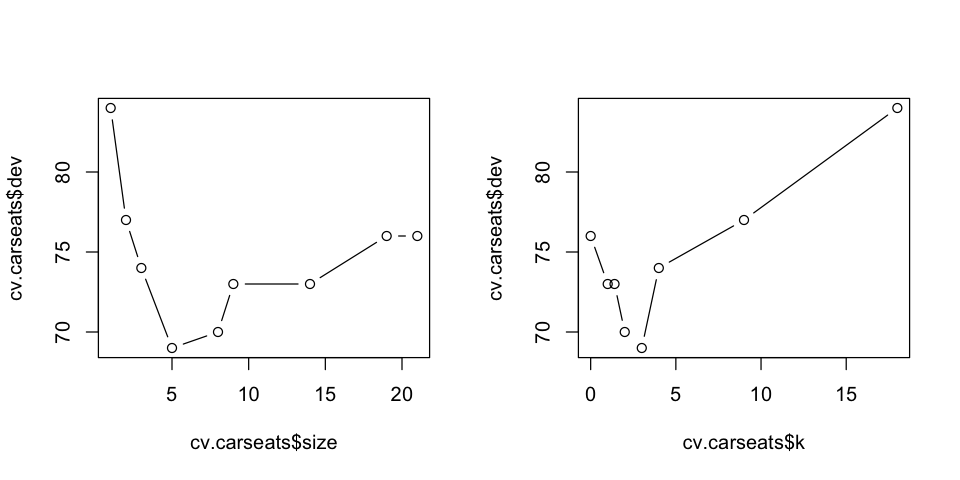

In [10]:
library(repr)
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
plot(cv.carseats$size,cv.carseats$dev,type="b")
plot(cv.carseats$k,cv.carseats$dev,type="b")

- We now apply the `prune.misclass()` function in order to prune the tree to obtain the five-node tree.

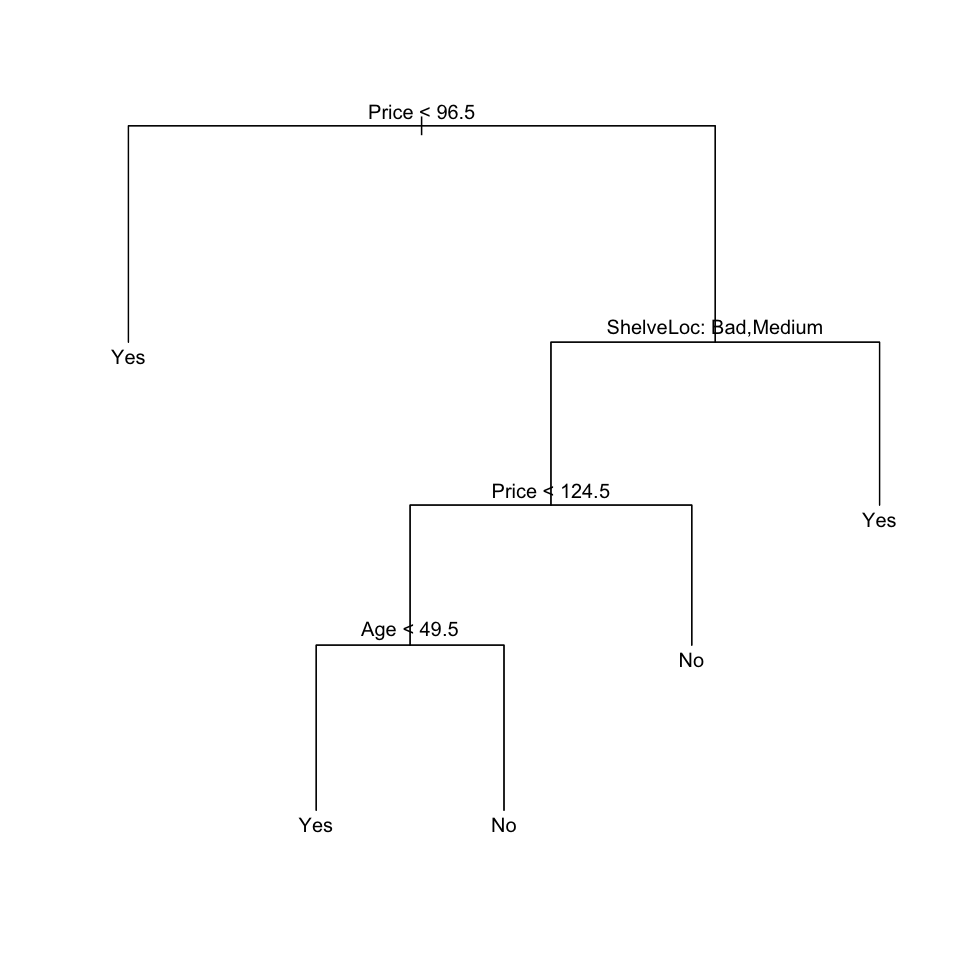

In [11]:
options(repr.plot.width=8, repr.plot.height=8)
prune.carseats=prune.misclass(tree.carseats,best=5)
plot(prune.carseats)
text(prune.carseats,pretty=0)

- How well does this pruned tree perform on the test data set?
- Once again, we apply the `predict()` function.

In [12]:
tree.pred=predict(prune.carseats,Carseats.test,type="class")
table(tree.pred,High.test)
(94+60)/200

         High.test
tree.pred No Yes
      No  82  16
      Yes 35  67

[1] 0.77

- Now 77% of the test observations are correctly classified, so not only has the pruning process produced a more interpretable tree, but it has also improved the classification accuracy.
- If we increase the value of `best`, we obtain a larger pruned tree with lower classification accuracy:

         High.test
tree.pred  No Yes
      No  102  30
      Yes  15  53

[1] 0.74

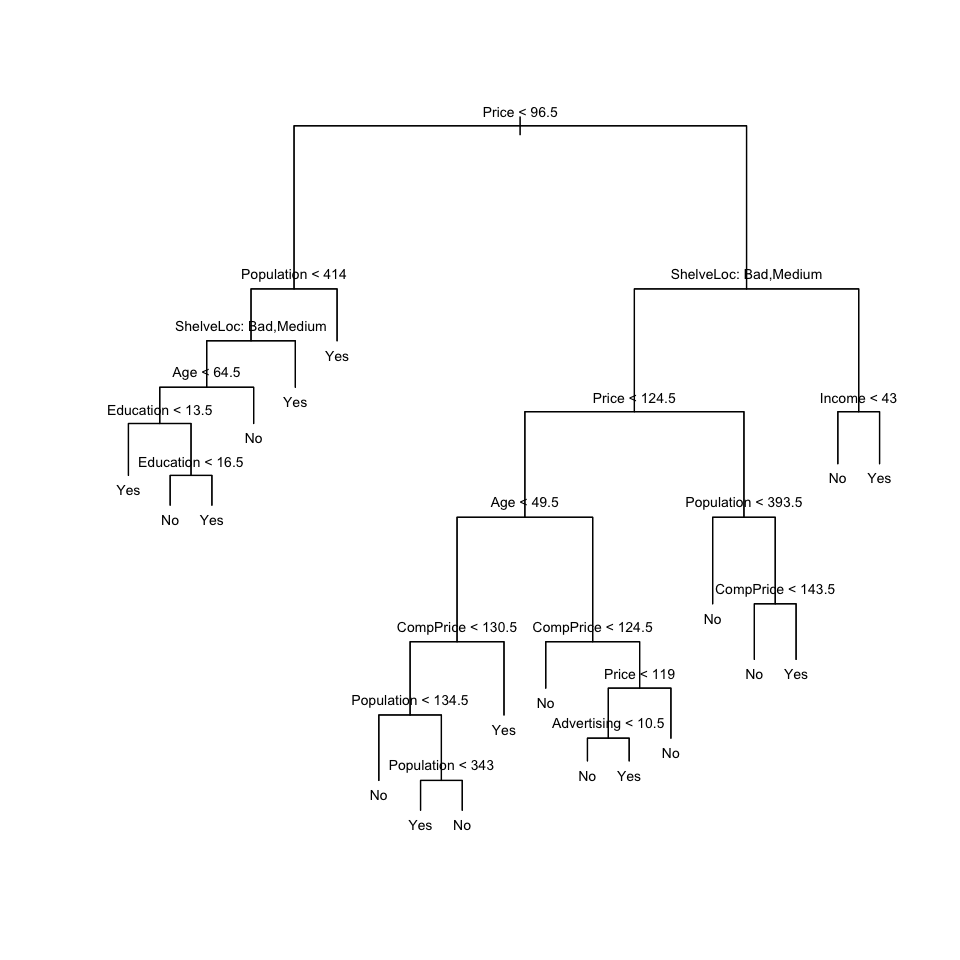

In [13]:
prune.carseats=prune.misclass(tree.carseats,best=15)
plot(prune.carseats)
text(prune.carseats,pretty=0,cex=0.7)
tree.pred=predict(prune.carseats,Carseats.test,type="class")
table(tree.pred,High.test)
(86+62)/200

## Regression trees
- Here we fit a regression tree to the `Boston` data set. First, we create a training set, and fit the tree to the training data.

In [14]:
# Fitting Regression Trees

library(MASS)
set.seed(1)
train = sample(1:nrow(Boston), nrow(Boston)/2)
tree.boston=tree(medv~.,Boston,subset=train)
summary(tree.boston)


Regression tree:
tree(formula = medv ~ ., data = Boston, subset = train)
Variables actually used in tree construction:
[1] "rm"    "lstat" "crim"  "age"  
Number of terminal nodes:  7 
Residual mean deviance:  10.38 = 2555 / 246 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-10.1800  -1.7770  -0.1775   0.0000   1.9230  16.5800 

- Notice that the output of `summary()` indicates that only four of the variables have been used in constructing the tree. 
- In the context of a regression tree, the deviance is simply the sum of squared errors for the tree. 
- We now plot the tree.

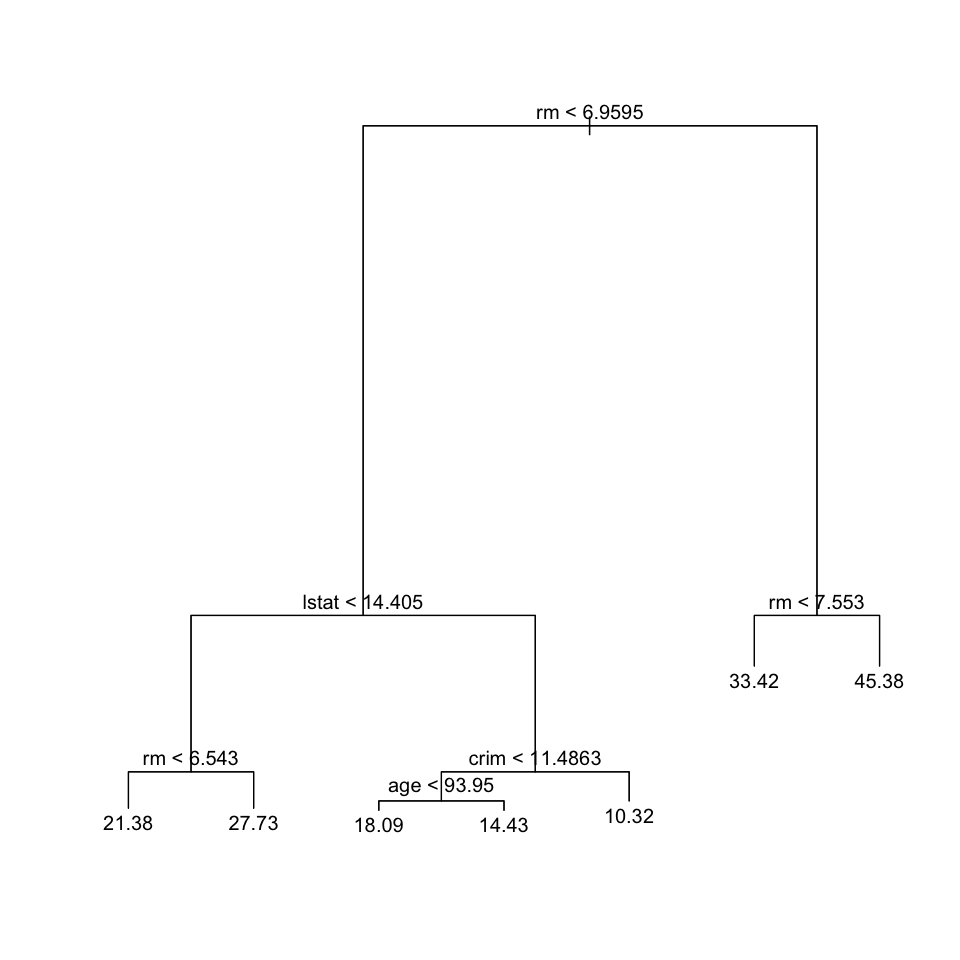

In [15]:
plot(tree.boston)
text(tree.boston,pretty=0)

- Now we use the `cv.tree()` function to see whether pruning the tree will improve performance.

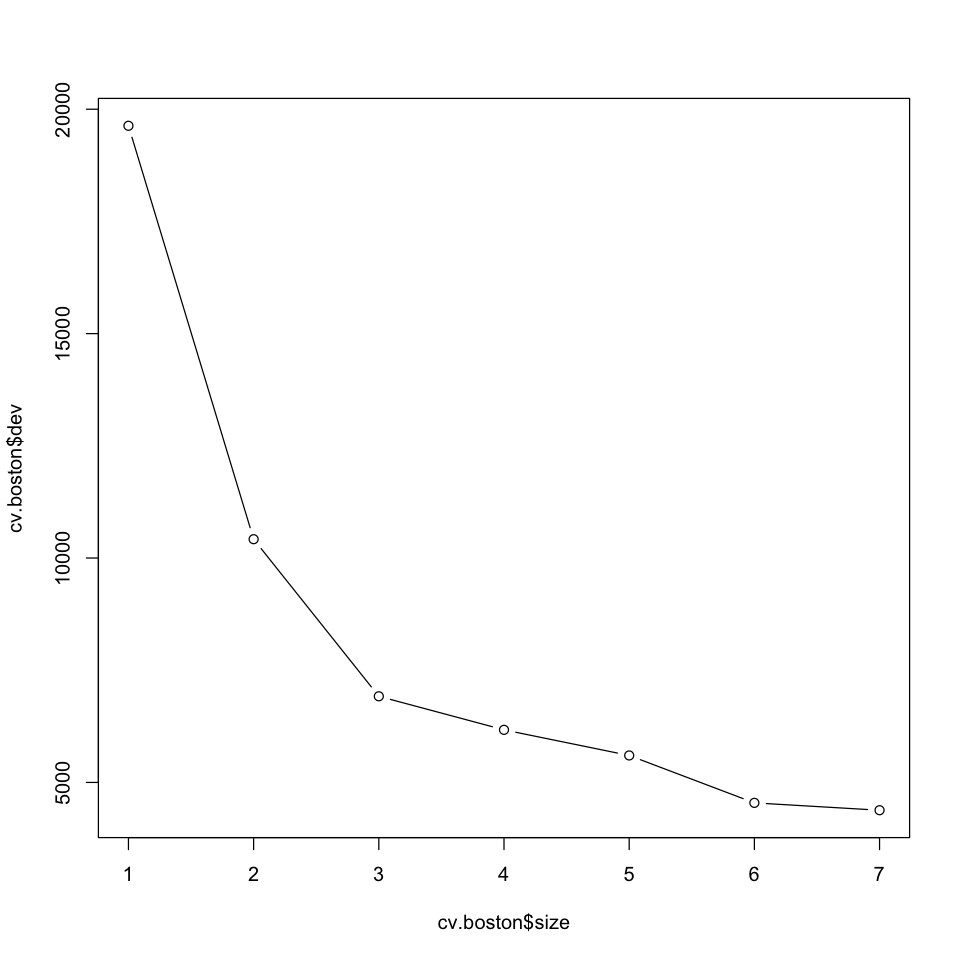

In [16]:
cv.boston=cv.tree(tree.boston)
plot(cv.boston$size,cv.boston$dev,type='b')

- In this case, the most complex tree is selected by cross-validation. 
- However, if we wish to prune the tree, we could do so as follows, using the `prune.tree()` function:

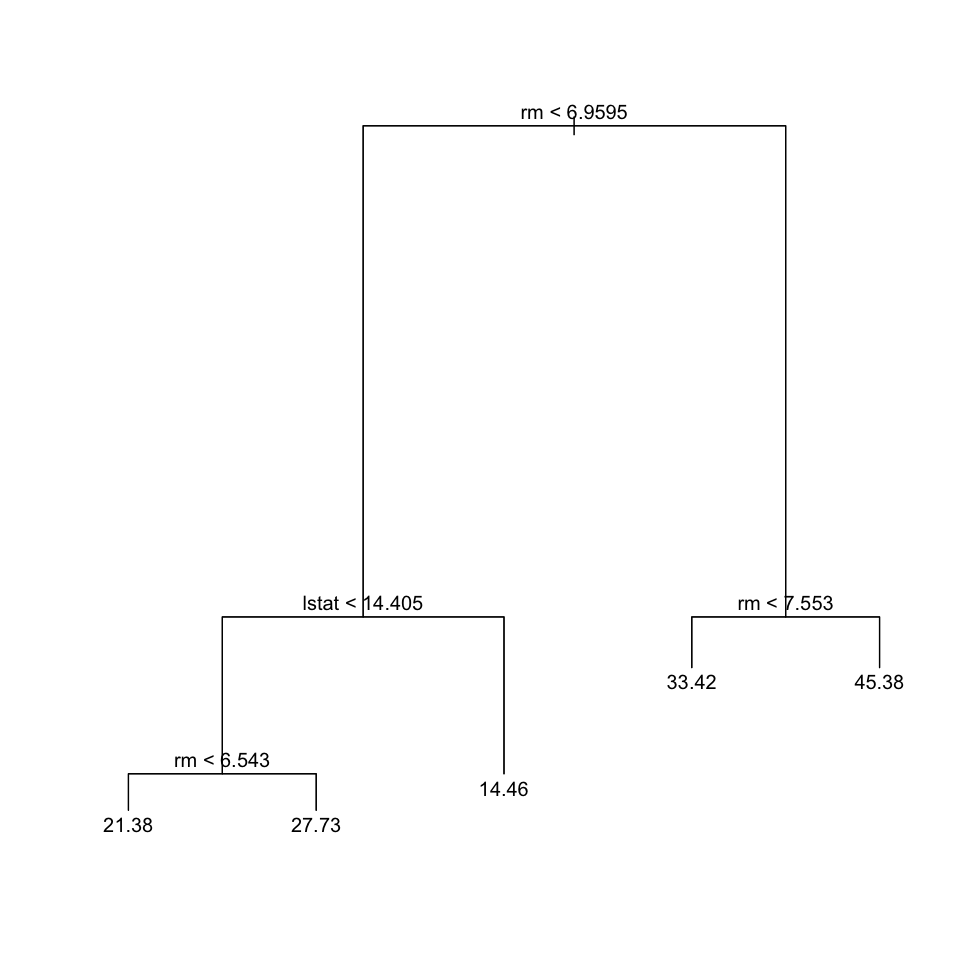

In [17]:
prune.boston=prune.tree(tree.boston,best=5)
plot(prune.boston)
text(prune.boston,pretty=0)

[1] 35.28688

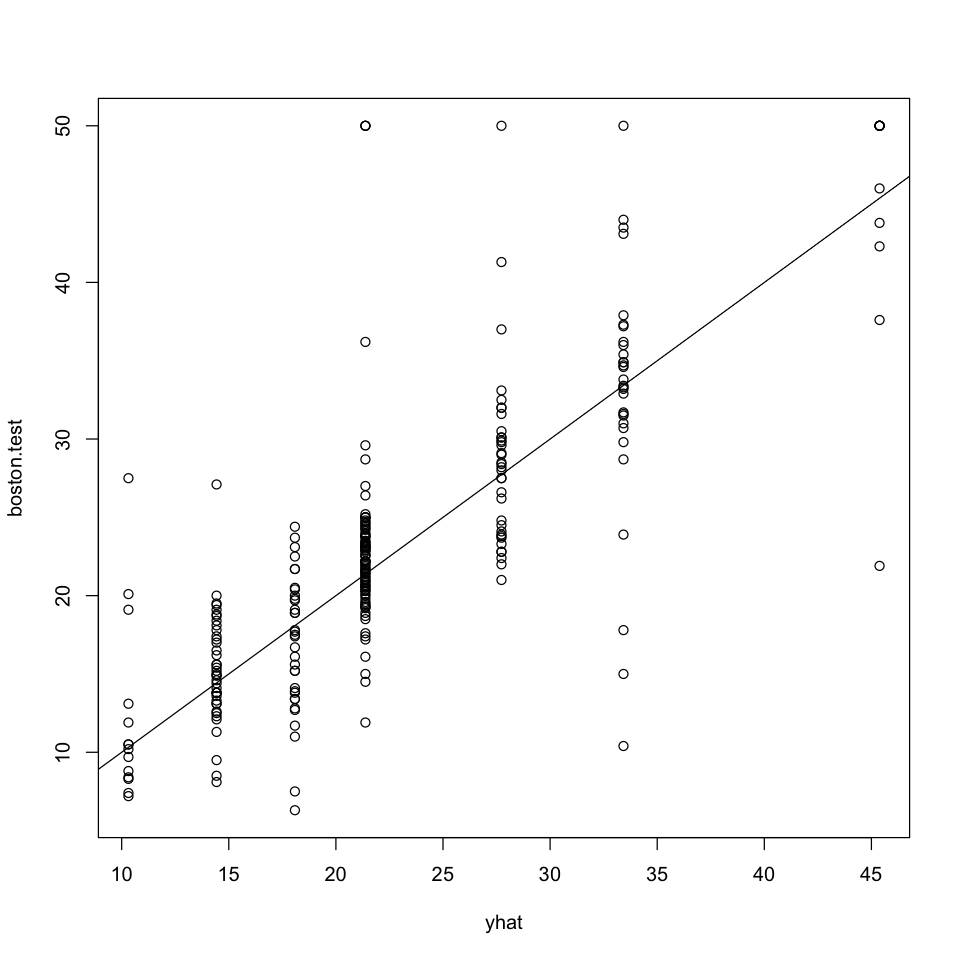

In [18]:
yhat=predict (tree.boston ,newdata =Boston[-train ,])
boston.test=Boston [-train ,"medv"]
plot(yhat ,boston.test)
abline (0,1)
mean((yhat -boston.test)^2)

## Bagging and Random Forest
- Here we apply bagging and random forests to the `Boston` data, using the `randomForest` package in R. 
- Recall that bagging is simply a special case of a random forest with m = p. 
- Therefore, the `randomForest()` function can be used to perform both random forests and bagging. 
- We perform bagging as follows:

In [19]:
# Bagging and Random Forests

library(randomForest)
set.seed(1)
bag.boston=randomForest(medv~.,data=Boston,subset=train,mtry=13,importance=TRUE)
bag.boston

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.



Call:
 randomForest(formula = medv ~ ., data = Boston, mtry = 13, importance = TRUE,      subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13

          Mean of squared residuals: 11.39601
                    % Var explained: 85.17

- The argument mtry=13 indicates that all 13 predictors should be considered for each split of the tree—in other words, that bagging should be done. 
- How well does this bagged model perform on the test set?

[1] 23.59273

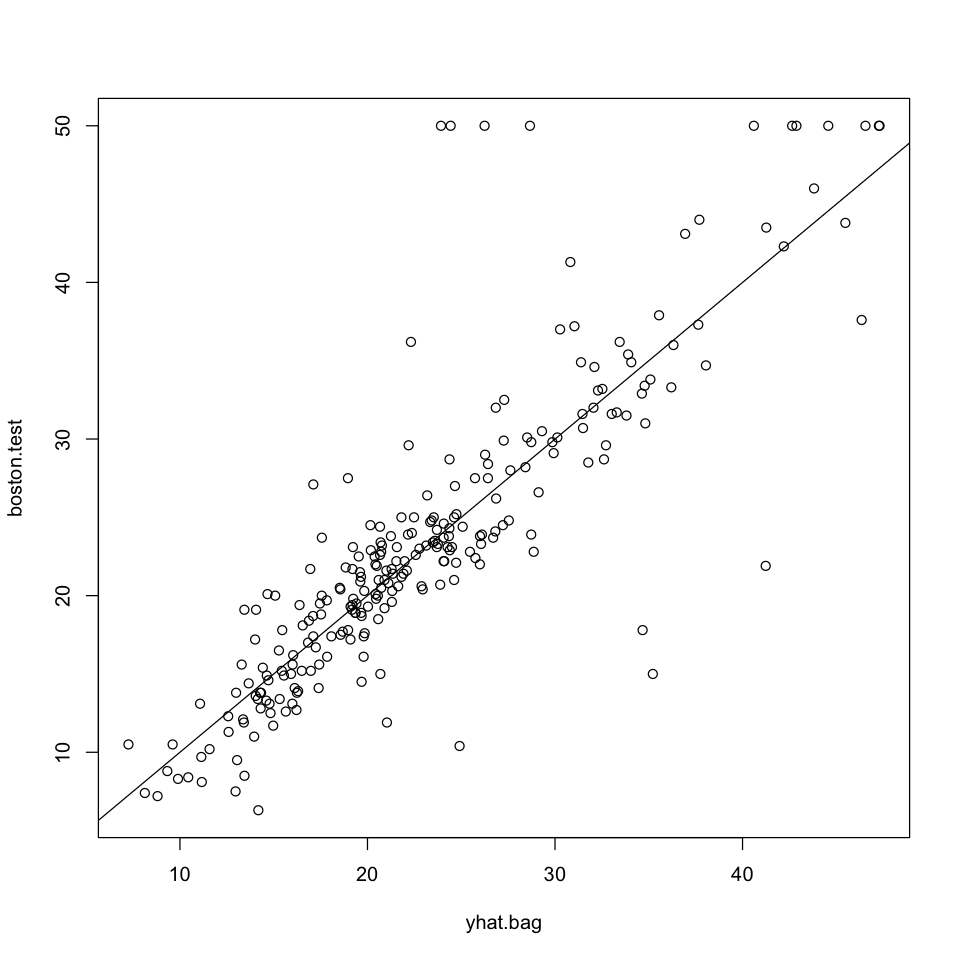

In [20]:
yhat.bag = predict(bag.boston,newdata=Boston[-train,])
plot(yhat.bag, boston.test)
abline(0,1)
mean((yhat.bag-boston.test)^2)

- We could change the number of trees grown by` randomForest()` using the `ntree` argument:

In [21]:
bag.boston=randomForest(medv~.,data=Boston,subset=train,mtry=13,ntree=25)
yhat.bag = predict(bag.boston,newdata=Boston[-train,])
mean((yhat.bag-boston.test)^2)

[1] 23.66716

- Growing a random forest proceeds in exactly the same way, except that we use a smaller value of the mtry argument. 
- By default, `randomForest()` uses p/3 variables when building a random forest of regression trees, and
$\sqrt{p}$ variables when building a random forest of classification trees.
- Here we use `mtry = 6`.

In [22]:
set.seed(1)
rf.boston=randomForest(medv~.,data=Boston,subset=train,mtry=6,importance=TRUE)
yhat.rf = predict(rf.boston,newdata=Boston[-train,])
mean((yhat.rf-boston.test)^2)

[1] 19.62021

- The test set MSE is 19.62; this indicates that random forests yielded an improvement over bagging in this case.

## Boosting
- Here we use the gbm package, and within it the gbm() function, to fit boosted `gbm()` regression trees to the `Boston` data set. 
- We run `gbm()` with the option `distribution="gaussian"` since this is a regression problem; if it were a binary classification problem, we would use `distribution="bernoulli"`.
- The argument `n.trees=5000` indicates that we want 5000 trees, and the option `interaction.depth=4` limits the depth of each tree.

In [23]:
# Boosting
library(gbm)
set.seed(1)
boost.boston=gbm(medv~.,data=Boston[train,],distribution="gaussian",n.trees=5000,interaction.depth=4)

Loaded gbm 2.1.5


In [24]:
yhat.boost=predict(boost.boston,newdata=Boston[-train,],n.trees=5000)
mean((yhat.boost-boston.test)^2)

[1] 18.84709

- The test MSE obtained is 18.33; similar to the test MSE for random forests and superior to that for bagging. 
- We can perform boosting with a different value of the shrinkage parameter $\lambda$. 
- The default value is 0.001, but this is easily modified. Here we take $\lambda = 0.2$.

In [25]:
boost.boston=gbm(medv~.,data=Boston[train,],distribution="gaussian",n.trees=5000,interaction.depth=4,
                 shrinkage=0.2,verbose=F)
yhat.boost=predict(boost.boston,newdata=Boston[-train,],n.trees=5000)
mean((yhat.boost-boston.test)^2)

[1] 18.33455

- We may perfrom cross-validation in `gbm` to evaluate model performance.

In [26]:
boost.boston=gbm(medv~.,data=Boston[train,],distribution="gaussian",
                 n.trees=500,interaction.depth=4,
                 shrinkage=0.1,cv.folds = 5,
                 verbose=T)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1       64.6407             nan     0.1000   11.8358
     2       54.9785             nan     0.1000    9.5967
     3       48.3602             nan     0.1000    6.5618
     4       42.4736             nan     0.1000    4.9034
     5       37.5062             nan     0.1000    5.1364
     6       32.4506             nan     0.1000    3.8617
     7       29.0461             nan     0.1000    3.5871
     8       25.3280             nan     0.1000    2.7732
     9       22.7319             nan     0.1000    2.6084
    10       20.2320             nan     0.1000    1.8796
    20        9.2798             nan     0.1000    0.2942
    40        5.6360             nan     0.1000   -0.0369
    60        3.9927             nan     0.1000   -0.0680
    80        3.1695             nan     0.1000   -0.0161
   100        2.5704             nan     0.1000   -0.0612
   120        2.2072             nan     0.1000   -0.0411
   140        

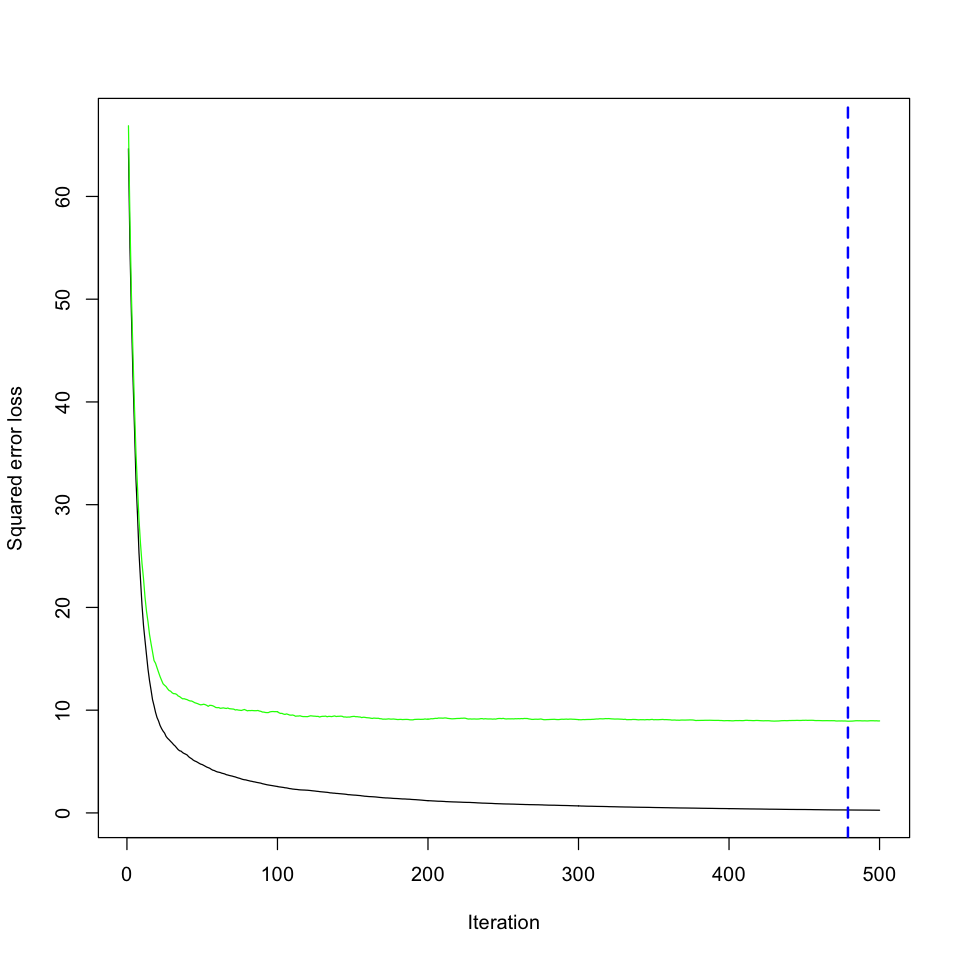

In [27]:
best.iter = gbm.perf(boost.boston, method = "cv")

In [28]:
yhat.boost=predict(boost.boston,newdata=Boston[-train,],n.trees=best.iter)

In [29]:
mean((yhat.boost-boston.test)^2)

[1] 19.45753